<a href="https://colab.research.google.com/github/himanshu-skid19/Unconditional-Image-Generation-Using-a-Diffusion-model/blob/master/Unconditional_Image_Generation_using_Diffusion_Models_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 778.0 kB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
import torch.nn.functional as F
import math
import numpy as np
import random
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial

In [3]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def show_images(dataset, num_samples=20, cols = 3):
  plt.figure(figsize=(15,15))
  for i, img in enumerate(dataset):
    if i == num_samples:
      break
    plt.subplot(int(num_samples/cols+1), cols, i+1)
    plt.imshow(img['images'][0])


In [6]:
from datasets import load_dataset, Image, Dataset

data = load_dataset("nelorth/oxford-flowers", split="train")
data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 7169
})

In [7]:
data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=523x500>,
 'label': 0}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize, Lambda
img_size = 64
transform = Compose([
        Resize([img_size, img_size]),
        CenterCrop(img_size),
        ToTensor(),
        Lambda(lambda t: (t * 2) - 1)
])

In [10]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [11]:
data_tensor = transform(data[0]['image']).unsqueeze_(0).to(device)

for i in tqdm(range(1, 1000)):
  x = transform(data[i]["image"]).unsqueeze_(0).to(device)
  data_tensor = torch.cat((data_tensor, x))

data_tensor.shape

  0%|          | 0/999 [00:00<?, ?it/s]

torch.Size([1000, 3, 64, 64])

In [12]:
BATCH_SIZE = 32
data_loader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size=BATCH_SIZE, shuffle = True, drop_last  =True)
data_loader

In [13]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def get_index_from_list(vals, t, x_shape):

    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

timesteps= 600
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [14]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

<ipython-input-15-a82e53f1f37c>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int((idx/stepsize)) + 1)


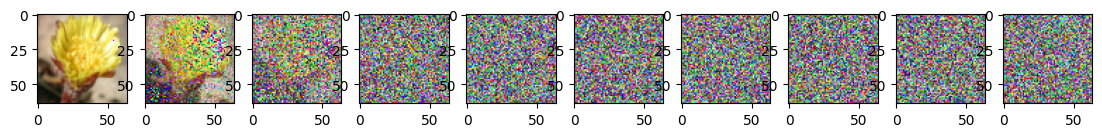

In [15]:
import numpy as np
image = next(iter(data_loader))[0]

plt.figure(figsize = (15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(0, timesteps, stepsize):
  t = torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1, num_images+1, int((idx/stepsize)) + 1)
  image, noise = forward_diffusion_sample(image, t)
  show_tensor_image(image)

In [16]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, t):
    device = t.device
    half_dim = self.dim//2
    embeddings = math.log(10000)/(half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device = device)*-embeddings)
    embeddings = t[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings


In [18]:
class Block(nn.Module):
  def __init__(self, dim, dim_out, groups = 8):
    super().__init__()
    self.conv = nn.Conv2d(dim, dim_out, 3, padding=1)
    self.norm = nn.GroupNorm(groups, dim_out)
    self.act = nn.SiLU()

  def forward(self, x, scale_shift = None):
    x= self.norm(self.conv(x))

    if exists(scale_shift):
      scale, shift = scale_shift
      x = x*(scale + 1) + shift

    x = self.act(x)
    return x

In [19]:
class ResnetBlock(nn.Module):
  def __init__(self, dim, dim_out, *, time_emb_dim=None, groups = 8):
    super().__init__()
    if exists(time_emb_dim):
      self.mlp = (nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out)))

    else:
      self.mlp = (None)

    self.block1 = Block(dim, dim_out, groups = groups)
    self.block2 = Block(dim_out, dim_out, groups = groups)
    if dim != dim_out:
      self.res_conv = nn.Conv2d(dim, dim_out, 1)
    else:
      self.res_conv = nn.Identity()

  def forward(self, x, time_emb = None):
    h = self.block1(x)

    if exists(self.mlp) and exists(time_emb):
      time_emb = self.mlp(time_emb)
      h = rearrange(time_emb, "b c -> b c 1 1") + h

    h = self.block2(h)
    return h + self.res_conv(x)

In [20]:
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [21]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [22]:
from torch.nn.modules.linear import Linear
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #scales the dimensions at different levels of the unet
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [23]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=img_size,
    channels=3,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  8244235


Unet(
  (init_conv): Conv2d(3, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (block1): Block(
          (conv): Conv2d(42, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(42, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): 

In [24]:
model = Unet(dim=img_size,
    channels=3,
    dim_mults=(1, 2, 4,))
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/model_400pt"))  ## run to load the pretrained model given in the drive, modify the path accordingly
model.to(device)
model

Unet(
  (init_conv): Conv2d(3, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (block1): Block(
          (conv): Conv2d(42, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(42, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): 

In [25]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)


In [26]:
@torch.no_grad()
def sample_timestep(x, t):

    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:

        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(timesteps/num_images)

    for i in range(0,timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)

        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [27]:
torch.cuda.empty_cache()


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0 | step 000 Loss: 0.10743489116430283 


<ipython-input-26-2a0d5d6bb7e1>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


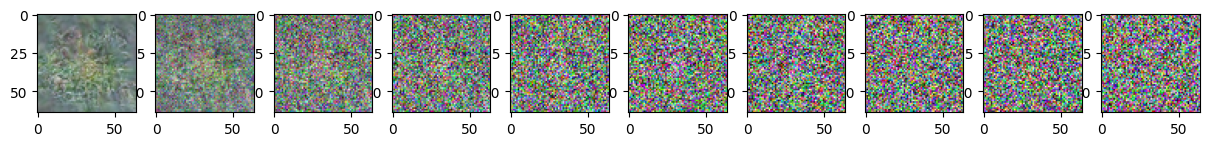

Epoch 0 | step 000 Loss: 0.10743489116430283 


0it [00:00, ?it/s]

Epoch 1 | step 000 Loss: 0.11537789553403854 


0it [00:00, ?it/s]

Epoch 2 | step 000 Loss: 0.08379358053207397 


0it [00:00, ?it/s]

Epoch 3 | step 000 Loss: 0.0958683043718338 


0it [00:00, ?it/s]

Epoch 4 | step 000 Loss: 0.12851396203041077 


0it [00:00, ?it/s]

Epoch 5 | step 000 Loss: 0.12386946380138397 


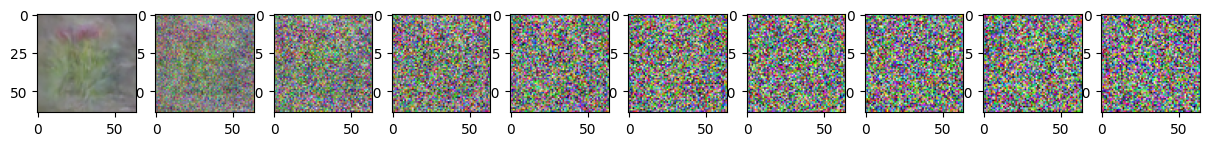

Epoch 5 | step 000 Loss: 0.12386946380138397 


0it [00:00, ?it/s]

Epoch 6 | step 000 Loss: 0.09801345318555832 


0it [00:00, ?it/s]

Epoch 7 | step 000 Loss: 0.10088211297988892 


0it [00:00, ?it/s]

Epoch 8 | step 000 Loss: 0.10896438360214233 


0it [00:00, ?it/s]

Epoch 9 | step 000 Loss: 0.08468548953533173 


0it [00:00, ?it/s]

Epoch 10 | step 000 Loss: 0.0658973902463913 


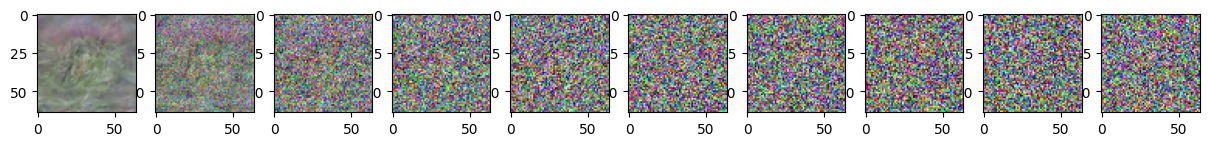

Epoch 10 | step 000 Loss: 0.0658973902463913 


0it [00:00, ?it/s]

Epoch 11 | step 000 Loss: 0.08515913784503937 


0it [00:00, ?it/s]

Epoch 12 | step 000 Loss: 0.10055120289325714 


0it [00:00, ?it/s]

Epoch 13 | step 000 Loss: 0.1060141921043396 


0it [00:00, ?it/s]

Epoch 14 | step 000 Loss: 0.09672015905380249 


0it [00:00, ?it/s]

Epoch 15 | step 000 Loss: 0.1034906804561615 


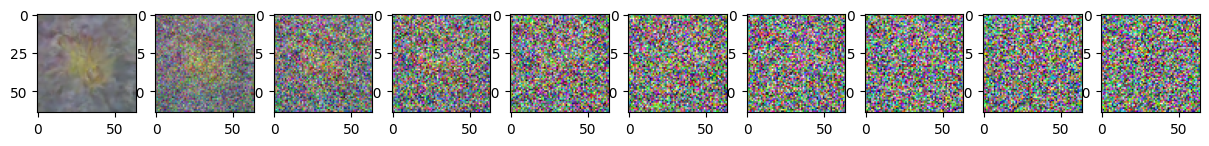

Epoch 15 | step 000 Loss: 0.1034906804561615 


0it [00:00, ?it/s]

Epoch 16 | step 000 Loss: 0.07945647090673447 


0it [00:00, ?it/s]

Epoch 17 | step 000 Loss: 0.10669800639152527 


0it [00:00, ?it/s]

Epoch 18 | step 000 Loss: 0.0934181809425354 


0it [00:00, ?it/s]

Epoch 19 | step 000 Loss: 0.12048035115003586 


0it [00:00, ?it/s]

Epoch 20 | step 000 Loss: 0.11955978721380234 


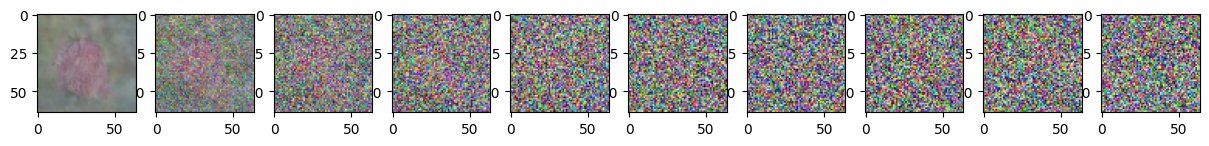

Epoch 20 | step 000 Loss: 0.11955978721380234 


0it [00:00, ?it/s]

Epoch 21 | step 000 Loss: 0.09266217052936554 


0it [00:00, ?it/s]

Epoch 22 | step 000 Loss: 0.10599406808614731 


0it [00:00, ?it/s]

Epoch 23 | step 000 Loss: 0.10377227514982224 


0it [00:00, ?it/s]

Epoch 24 | step 000 Loss: 0.10889391601085663 


0it [00:00, ?it/s]

Epoch 25 | step 000 Loss: 0.11751934140920639 


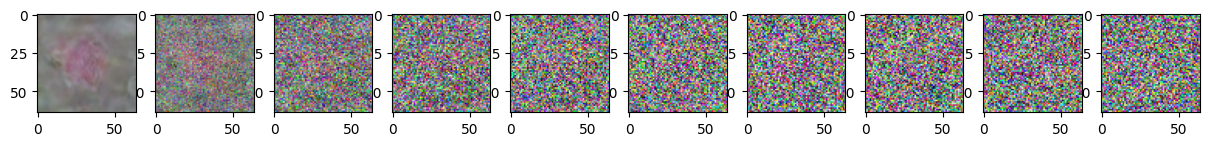

Epoch 25 | step 000 Loss: 0.11751934140920639 


0it [00:00, ?it/s]

Epoch 26 | step 000 Loss: 0.12137248367071152 


0it [00:00, ?it/s]

Epoch 27 | step 000 Loss: 0.10518207401037216 


0it [00:00, ?it/s]

Epoch 28 | step 000 Loss: 0.09746862947940826 


0it [00:00, ?it/s]

Epoch 29 | step 000 Loss: 0.10215797275304794 


0it [00:00, ?it/s]

Epoch 30 | step 000 Loss: 0.12222272157669067 


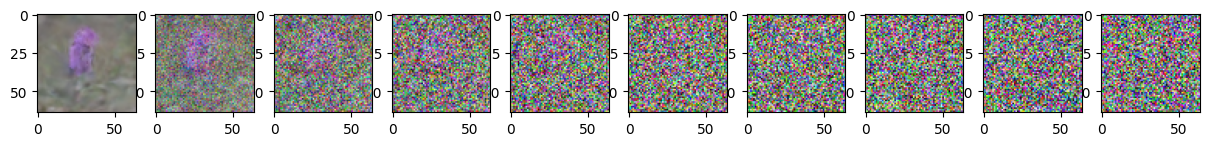

Epoch 30 | step 000 Loss: 0.12222272157669067 


0it [00:00, ?it/s]

Epoch 31 | step 000 Loss: 0.07901127636432648 


0it [00:00, ?it/s]

Epoch 32 | step 000 Loss: 0.1436193436384201 


0it [00:00, ?it/s]

Epoch 33 | step 000 Loss: 0.0872856080532074 


0it [00:00, ?it/s]

Epoch 34 | step 000 Loss: 0.08818124234676361 


0it [00:00, ?it/s]

Epoch 35 | step 000 Loss: 0.0977635383605957 


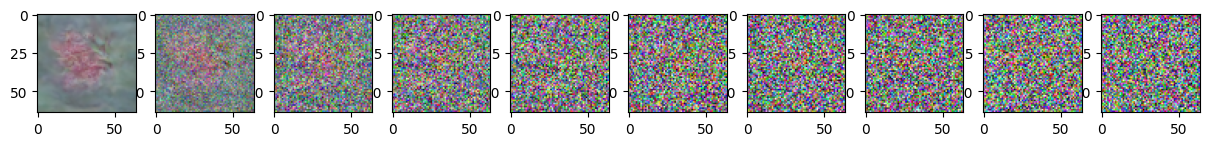

Epoch 35 | step 000 Loss: 0.0977635383605957 


0it [00:00, ?it/s]

Epoch 36 | step 000 Loss: 0.1189742386341095 


0it [00:00, ?it/s]

Epoch 37 | step 000 Loss: 0.11549955606460571 


0it [00:00, ?it/s]

Epoch 38 | step 000 Loss: 0.1335248351097107 


0it [00:00, ?it/s]

Epoch 39 | step 000 Loss: 0.12853586673736572 


0it [00:00, ?it/s]

Epoch 40 | step 000 Loss: 0.10108429193496704 


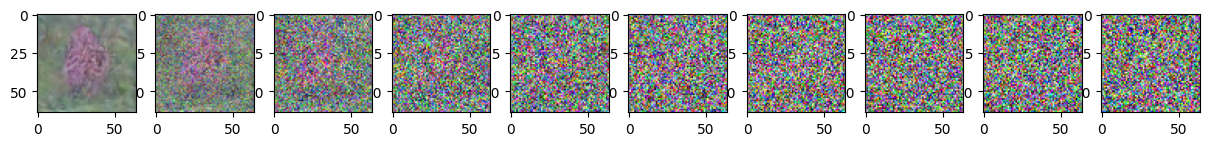

Epoch 40 | step 000 Loss: 0.10108429193496704 


0it [00:00, ?it/s]

Epoch 41 | step 000 Loss: 0.13600453734397888 


0it [00:00, ?it/s]

Epoch 42 | step 000 Loss: 0.12186767160892487 


0it [00:00, ?it/s]

Epoch 43 | step 000 Loss: 0.10737719386816025 


0it [00:00, ?it/s]

Epoch 44 | step 000 Loss: 0.09368918836116791 


0it [00:00, ?it/s]

Epoch 45 | step 000 Loss: 0.11617404222488403 


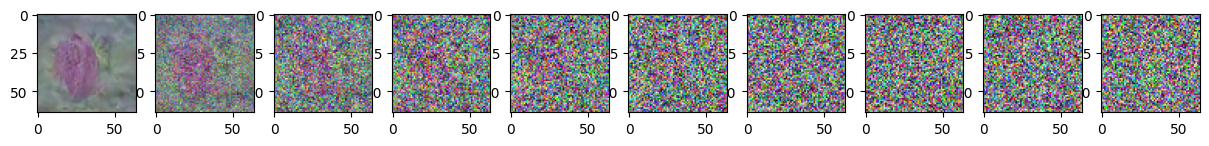

Epoch 45 | step 000 Loss: 0.11617404222488403 


0it [00:00, ?it/s]

Epoch 46 | step 000 Loss: 0.07019800692796707 


0it [00:00, ?it/s]

Epoch 47 | step 000 Loss: 0.10651173442602158 


0it [00:00, ?it/s]

Epoch 48 | step 000 Loss: 0.13125944137573242 


0it [00:00, ?it/s]

Epoch 49 | step 000 Loss: 0.09877799451351166 


In [28]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 50
for epoch in tqdm(range(epochs)):
    for step, batch in tqdm(enumerate(data_loader)):
      optimizer.zero_grad()

      t = torch.randint(0, timesteps, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch, t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
      if step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

In [29]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [30]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)

        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), 3)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [31]:
samples = sample(model, image_size=64, batch_size=64, channels=3)

sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

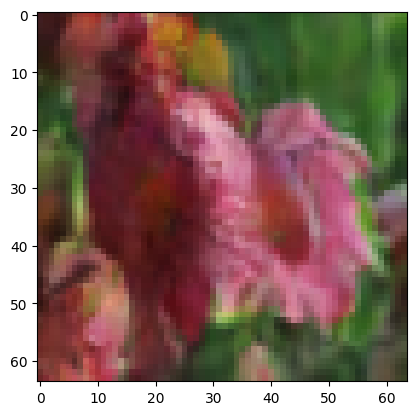

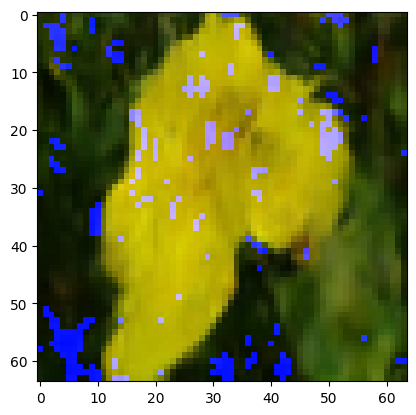

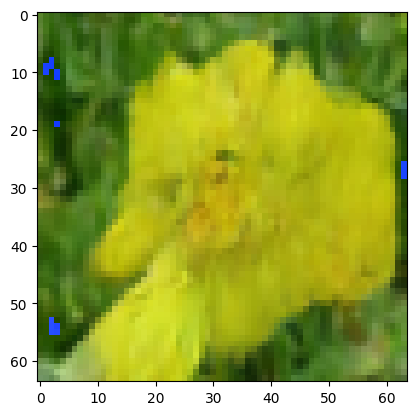

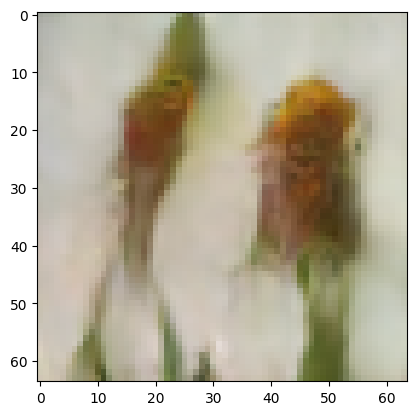

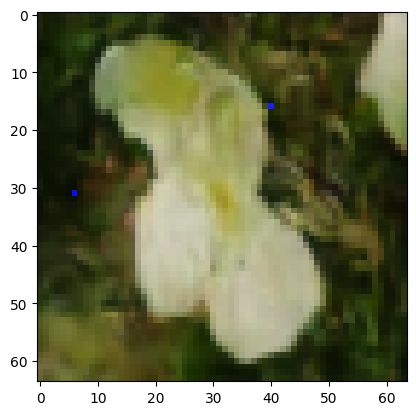

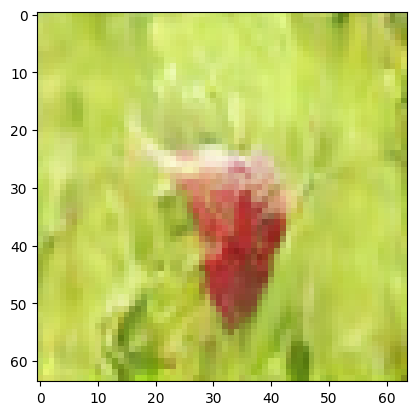

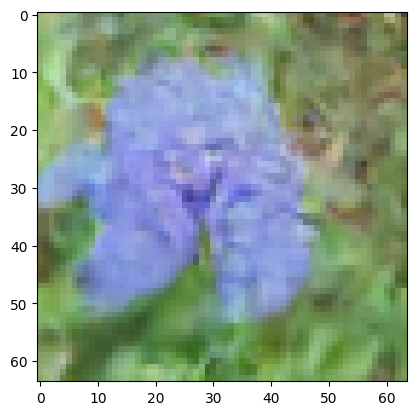

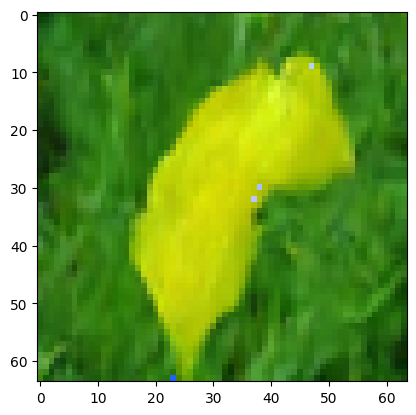

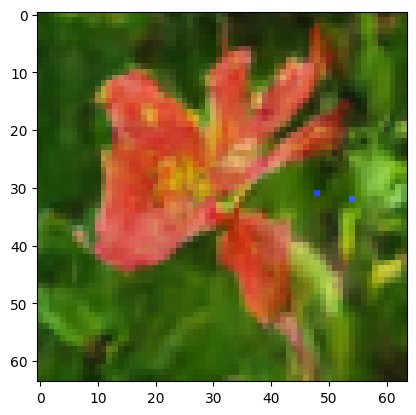

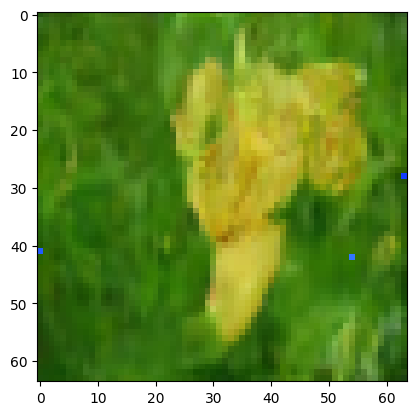

In [32]:
reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

for i in random.sample(range(0, 64), 10):
    img  = torch.Tensor((samples[-1][i].reshape(3, 64, 64)))
    show_tensor_image(img)
    plt.show()

# img  = reverse_transforms(torch.Tensor((samples[-1][63].reshape(3, 64, 64))))
# plt.imshow(img)

In [33]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/model_450pt") ## run if you want to save the model to drive, modify according to where you want to save the model